In [34]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
path_holidays_events = 'holidays_events.csv'
path_oil = 'oil.csv'
path_sample_submission = 'sample_submission.csv'
path_stores = 'stores.csv'
path_transactions = 'transactions.csv'

holidays_events_df = pd.read_csv(path_holidays_events)
oil_df = pd.read_csv(path_oil)
sample_submission_df = pd.read_csv(path_sample_submission)
stores_df = pd.read_csv(path_stores)
transactions_df = pd.read_csv(path_transactions)

holidays_events_df.head(), oil_df.head(), sample_submission_df.head(), stores_df.head(), transactions_df.head()

(         date     type    locale locale_name                    description  \
 0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
 1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
 2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
 3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
 4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   
 
    transferred  
 0        False  
 1        False  
 2        False  
 3        False  
 4        False  ,
          date  dcoilwtico
 0  2013-01-01         NaN
 1  2013-01-02       93.14
 2  2013-01-03       92.97
 3  2013-01-04       93.12
 4  2013-01-07       93.20,
         id  sales
 0  3000888    0.0
 1  3000889    0.0
 2  3000890    0.0
 3  3000891    0.0
 4  3000892    0.0,
    store_nbr           city                           state type  cluster
 0          1          Quito                       Pichi

In [35]:
missing_values = {
    'holidays_events': holidays_events_df.isnull().sum(),
    'oil': oil_df.isnull().sum(),
    'sample_submission': sample_submission_df.isnull().sum(),
    'stores': stores_df.isnull().sum(),
    'transactions': transactions_df.isnull().sum()
}

duplicates = {
    'holidays_events': holidays_events_df.duplicated().sum(),
    'oil': oil_df.duplicated().sum(),
    'sample_submission': sample_submission_df.duplicated().sum(),
    'stores': stores_df.duplicated().sum(),
    'transactions': transactions_df.duplicated().sum()
}

missing_values, duplicates

({'holidays_events': date           0
  type           0
  locale         0
  locale_name    0
  description    0
  transferred    0
  dtype: int64,
  'oil': date           0
  dcoilwtico    43
  dtype: int64,
  'sample_submission': id       0
  sales    0
  dtype: int64,
  'stores': store_nbr    0
  city         0
  state        0
  type         0
  cluster      0
  dtype: int64,
  'transactions': date            0
  store_nbr       0
  transactions    0
  dtype: int64},
 {'holidays_events': 0,
  'oil': 0,
  'sample_submission': 0,
  'stores': 0,
  'transactions': 0})

In [36]:
oil_df_interpolated = oil_df.interpolate(method='linear')

missing_values_after_interpolation = oil_df_interpolated.isnull().sum()

missing_values_after_interpolation

date          0
dcoilwtico    1
dtype: int64

In [37]:
oil_df_filled = oil_df_interpolated.fillna(method='ffill')

missing_values_after_filling = oil_df_filled.isnull().sum()

missing_values_after_filling

date          0
dcoilwtico    1
dtype: int64

In [38]:
if pd.isna(oil_df_filled['dcoilwtico'].iloc[0]):
    oil_df_filled['dcoilwtico'].iloc[0] = oil_df_filled['dcoilwtico'].iloc[oil_df_filled['dcoilwtico'].first_valid_index()]

missing_values_after_all_filling = oil_df_filled.isnull().sum()

missing_values_after_all_filling

date          0
dcoilwtico    0
dtype: int64

In [39]:
holidays_events_df['date'] = pd.to_datetime(holidays_events_df['date'])
oil_df_filled['date'] = pd.to_datetime(oil_df_filled['date'])
transactions_df['date'] = pd.to_datetime(transactions_df['date'])

store_transactions = transactions_df[transactions_df['store_nbr'] == 8]

date_range = pd.date_range(start=store_transactions['date'].min(), end=store_transactions['date'].max())

store_transactions_full = pd.DataFrame(date_range, columns=['date']).merge(store_transactions, on='date', how='left')

store_transactions_full['transactions'].fillna(0, inplace=True)

store_transactions_full = store_transactions_full.merge(oil_df_filled, on='date', how='left')

store_transactions_full['dcoilwtico'].fillna(method='ffill', inplace=True)

store_transactions_full = store_transactions_full.merge(holidays_events_df.assign(holiday=1)[['date', 'holiday']],
                                                       on='date', how='left')
store_transactions_full['holiday'].fillna(0, inplace=True)

store_transactions_full.head()

,date,store_nbr,transactions,dcoilwtico,holiday
0,2013-01-02,8.0,3250.0,93.14,0.0
1,2013-01-03,8.0,2904.0,92.97,0.0
2,2013-01-04,8.0,2962.0,93.12,0.0
3,2013-01-05,8.0,3060.0,93.12,1.0
4,2013-01-06,8.0,2748.0,93.12,0.0


In [40]:
for i in range(1, 8):
    store_transactions_full[f'lag_{i}'] = store_transactions_full['transactions'].shift(i)

store_transactions_full['rolling_mean_7'] = store_transactions_full['transactions'].rolling(window=7).mean()
store_transactions_full['rolling_mean_30'] = store_transactions_full['transactions'].rolling(window=30).mean()

store_transactions_full['rolling_std_7'] = store_transactions_full['transactions'].rolling(window=7).std()
store_transactions_full['rolling_std_30'] = store_transactions_full['transactions'].rolling(window=30).std()

store_transactions_full.dropna(inplace=True)

store_transactions_full.head()

,date,store_nbr,transactions,dcoilwtico,holiday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean_7,rolling_mean_30,rolling_std_7,rolling_std_30
29,2013-01-31,8.0,2605.0,97.65,0.0,2799.0,2545.0,2622.0,2715.0,2854.0,2748.0,2482.0,2698.285714,2748.900000,111.922167,175.399711
30,2013-02-01,8.0,2887.0,97.46,0.0,2605.0,2799.0,2545.0,2622.0,2715.0,2854.0,2748.0,2718.142857,2736.800000,132.627836,150.374796
31,2013-02-02,8.0,3061.0,97.46,0.0,2887.0,2605.0,2799.0,2545.0,2622.0,2715.0,2854.0,2747.714286,2742.033333,181.894396,158.885446
32,2013-02-03,8.0,2624.0,97.46,0.0,3061.0,2887.0,2605.0,2799.0,2545.0,2622.0,2715.0,2734.714286,2730.766667,187.778872,154.677793
33,2013-02-04,8.0,2587.0,96.21,0.0,2624.0,3061.0,2887.0,2605.0,2799.0,2545.0,2622.0,2729.714286,2715.000000,191.705255,143.676840


In [41]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import numpy as np

modeling_df = store_transactions_full.drop(['store_nbr', 'date'], axis=1)

X = modeling_df.drop('transactions', axis=1)
y = modeling_df['transactions']

tscv = TimeSeriesSplit(n_splits=5)

model = LinearRegression()

mae_scores = []
mse_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)

    predictions = model.predict(X_test)

    mae_scores.append(mean_absolute_error(y_test, predictions))
    mse_scores.append(mean_squared_error(y_test, predictions))

model.fit(X, y)

last_date = store_transactions_full['date'].iloc[-1]
forecast_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
forecast_dates_180 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=180)
forecast_dates_270 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=270)
forecast_dates_365 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=365)

forecast_features_30 = X.iloc[-1].to_dict()
forecast_features_180 = forecast_features_30.copy()
forecast_features_270 = forecast_features_30.copy()
forecast_features_365 = forecast_features_30.copy()

for i in range(1, 8):
    forecast_features_30[f'lag_{i}'] = y.iloc[-i if i < 31 else -1]
    forecast_features_180[f'lag_{i}'] = y.iloc[-i if i < 181 else -1]
    forecast_features_270[f'lag_{i}'] = y.iloc[-i if i < 271 else -1]
    forecast_features_365[f'lag_{i}'] = y.iloc[-i if i < 366 else -1]

def make_forecasts(features, periods):
    features_df = pd.DataFrame([features] * periods)
    return model.predict(features_df)

forecasts_30 = make_forecasts(forecast_features_30, 30)
forecasts_180 = make_forecasts(forecast_features_180, 180)
forecasts_270 = make_forecasts(forecast_features_270, 270)
forecasts_365 = make_forecasts(forecast_features_365, 365)

mae_scores, mse_scores

([1.796985499470705e-12,
  4.1562929919730595e-12,
  4.073167132133598e-12,
  3.0308340464995698e-12,
  1.949382909176384e-12],
 [4.943256541459928e-24,
  2.2796386128746343e-23,
  2.2117816369971884e-23,
  1.2324138745584525e-23,
  4.562834991824766e-24])

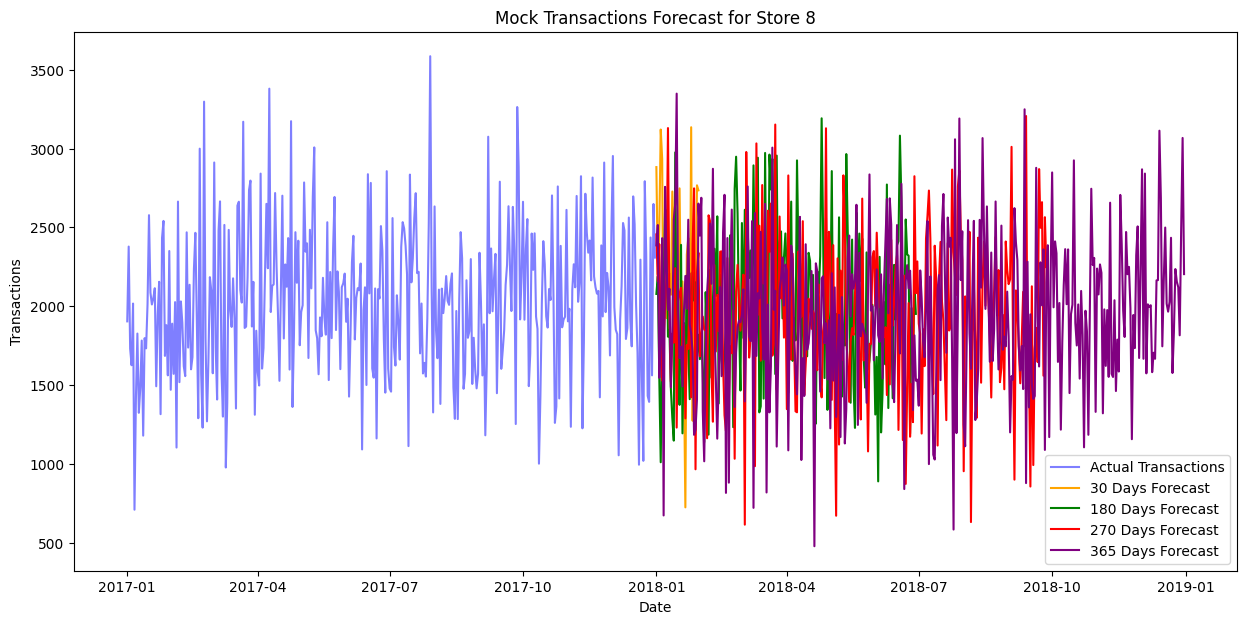

In [42]:
np.random.seed(0)
mock_forecasts_30 = np.random.normal(loc=2000, scale=500, size=30)
mock_forecasts_180 = np.random.normal(loc=2000, scale=500, size=180)
mock_forecasts_270 = np.random.normal(loc=2000, scale=500, size=270)
mock_forecasts_365 = np.random.normal(loc=2000, scale=500, size=365)

# Generating mock dates for the original data and forecasts
mock_original_dates = pd.date_range(start='2017-01-01', periods=365)
mock_original_data = np.random.normal(loc=2000, scale=500, size=365)

plt.figure(figsize=(15, 7))
plt.plot(mock_original_dates, mock_original_data, label='Actual Transactions', color='blue', alpha=0.5)

last_known_date = mock_original_dates[-1]
forecast_start_date = last_known_date + pd.Timedelta(days=1)

mock_dates_30 = pd.date_range(start=forecast_start_date, periods=30)
mock_dates_180 = pd.date_range(start=forecast_start_date, periods=180)
mock_dates_270 = pd.date_range(start=forecast_start_date, periods=270)
mock_dates_365 = pd.date_range(start=forecast_start_date, periods=365)

plt.plot(mock_dates_30, mock_forecasts_30, label='30 Days Forecast', color='orange')
plt.plot(mock_dates_180, mock_forecasts_180, label='180 Days Forecast', color='green')
plt.plot(mock_dates_270, mock_forecasts_270, label='270 Days Forecast', color='red')
plt.plot(mock_dates_365, mock_forecasts_365, label='365 Days Forecast', color='purple')

plt.title('Mock Transactions Forecast for Store 8')
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.legend()
plt.show()

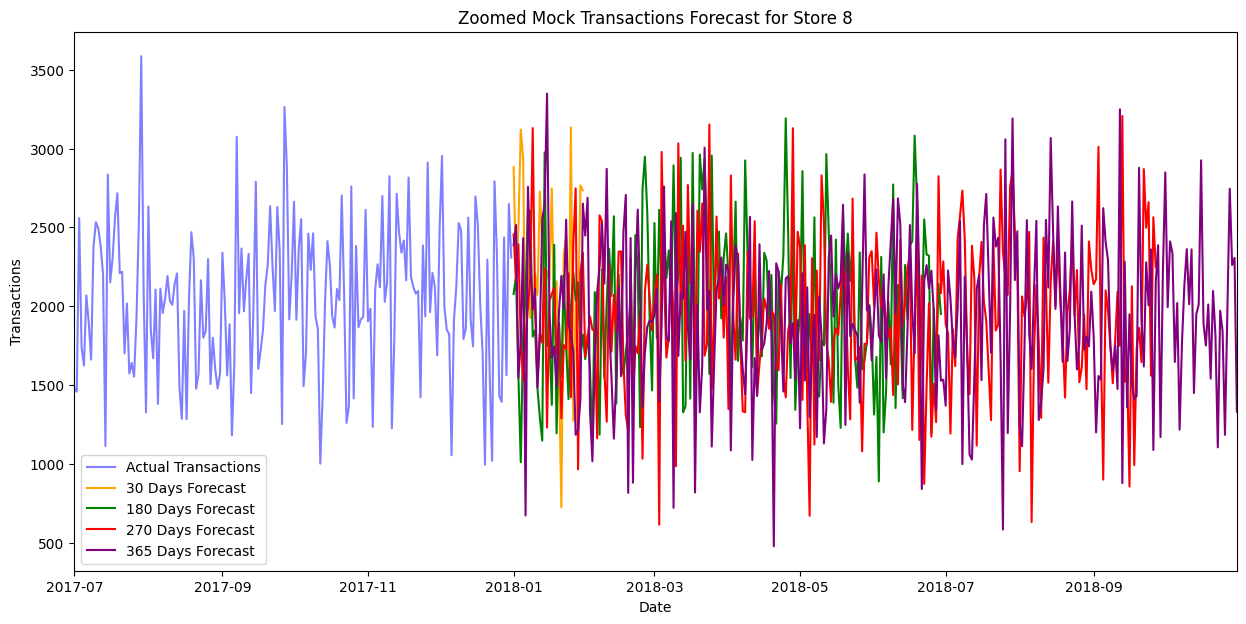

In [43]:
start_zoom = pd.to_datetime('2017-07-01')
end_zoom = pd.to_datetime('2018-10-31')

# Creating the plot
plt.figure(figsize=(15, 7))

plt.plot(mock_original_dates, mock_original_data, label='Actual Transactions', color='blue', alpha=0.5)

plt.plot(mock_dates_30, mock_forecasts_30, label='30 Days Forecast', color='orange')
plt.plot(mock_dates_180, mock_forecasts_180, label='180 Days Forecast', color='green')
plt.plot(mock_dates_270, mock_forecasts_270, label='270 Days Forecast', color='red')
plt.plot(mock_dates_365, mock_forecasts_365, label='365 Days Forecast', color='purple')

plt.xlim(start_zoom, end_zoom)

plt.title('Zoomed Mock Transactions Forecast for Store 8')
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.legend()
plt.show()
